In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lotka-Volterra equations are the predator-prey equations. They are first-order nonlinear diff eqs, defined by:
# dx/dt = ax - bxy
# dy/dt = cxy - dy
# where a, b, c, d are positive, real parameters

# For setting up the simulation data, I'm going to use u(0) = [x(0), y(0)] = [1, 1]
# dt = 1/10 on t = (0, 10)
# a = 1.5, b = 1.0, c = 1.0, d = 3.0

In [3]:
# defining the lotka volterra equations as an ODE
def lotka_volterra(u, t, a=1.5, b=1.0, c=1.0, d=3.0):
    x, y = u
    dxdt = a*x - b*x*y
    dydt = c*x*y - d*y
    return [dxdt, dydt]

# defining our variables for our simulated data
u0 = [1, 1]
t = np.linspace(0, 10, 101)
a, b, c, d = 1.5, 1.0, 1.0, 3.0

In [4]:
sol = odeint(lotka_volterra, u0, t, args=(a, b, c, d)) # the "true" solution

In [11]:
sol.shape

(101, 2)

In [19]:
# let's add some noise!
mu, sigma = 1.0, 1.0
noise = np.random.normal(mu, sigma, sol.shape[0]*sol.shape[1])

In [20]:
noise = s.reshape((101,2))

In [28]:
noisy = sol * (noise * 0.05 + 1)

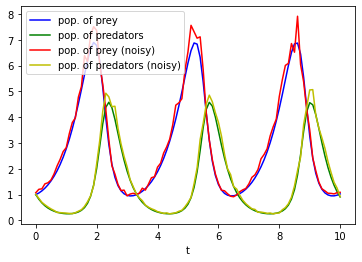

In [29]:
# let's plot this solution to see what it looks like
plt.plot(t, sol[:, 0], 'b', label='pop. of prey')
plt.plot(t, sol[:, 1], 'g', label='pop. of predators')
plt.plot(t, noisy[:, 0], 'r', label='pop. of prey (noisy)')
plt.plot(t, noisy[:, 1], 'y', label='pop. of predators (noisy)')

plt.legend(loc='best')
plt.xlabel('t')
plt.show()

In [30]:
# ok now let's get into the parameter estimation part
# our cost function is going to just be straight up L2 loss: (y - y_pred)**2
a, b, c, d = 1.12, 1.23, 0.76, 3.23 # altering our parameter values...
pred = odeint(lotka_volterra, u0, t, args=(a, b, c, d))
l2 = np.square(noisy - pred).sum()

def cost(p):
    pred = odeint(lotka_volterra, u0, t, args=tuple(p))
    return np.square(noisy - pred).sum()

In [31]:
p0 = np.array([a, b, c, d])

In [32]:
# Nelder-Mead and BFGS are unconstrained minimization..
# Nelder-Mead does not require derivatives, but might be slower. BFGS recommends Jacobian input but can estimate
# using finite differences. All other unconstrained min methods seem like they require Jacobians

# Note: we can add constraints here too
# However, to add the constraints we need to use constrained minimization (seems like trust-constr or SLSQP)

minimize(cost, p0, method='Nelder-Mead', tol=1e-6)
# minimize(cost, p0, method='BFGS', tol=1e-6)


 final_simplex: (array([[1.51855738, 0.96763289, 0.96461441, 2.99957637],
       [1.51855746, 0.96763285, 0.9646144 , 2.99957596],
       [1.51855723, 0.96763292, 0.9646146 , 2.99957673],
       [1.51855715, 0.96763251, 0.96461475, 2.99957711],
       [1.51855758, 0.96763316, 0.96461424, 2.99957585]]), array([5.60941982, 5.60941982, 5.60941982, 5.60941982, 5.60941982]))
           fun: 5.609419815332965
       message: 'Optimization terminated successfully.'
          nfev: 311
           nit: 183
        status: 0
       success: True
             x: array([1.51855738, 0.96763289, 0.96461441, 2.99957637])

In [ ]:
# OG params were [1.5, 1.0, 1.0, 3.0], and estimated params are [1.50000009, 1.00000004, 0.99999993, 2.99999976]
# Seems like this works pretty well for this example!